In [1]:
!../doDownload

/bin/bash: ../doDownload: No such file or directory


In [235]:
from anndata import AnnData
import pandas as pd
import csv

import cellrank as  cr
import scanpy as sc
from scipy import sparse

import umap
import copy as cp
    
import scipy.sparse as sp

from harmony import harmonize

In [267]:
def calculate_entropy_per_tf(adata):
    # Count the frequency of each TF in each cluster
    frequency_table = adata.obs.groupby(['TF', 'difflouvain']).size().unstack(fill_value=0)
    
    # Convert counts to probabilities
    probabilities = frequency_table.div(frequency_table.sum(axis=1), axis=0)
    
    # Calculate entropy for each TF
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9), axis=1)  # Adding a small value to avoid log(0)
    
    return entropy


def plot_umap(adata, pca_key='X_pca', umap_key='umap', title_prefix=''):
    # Initialize UMAP reducer
    reducer = umap.UMAP()

    # Fit the UMAP model using your selected PCA data
    embedding = reducer.fit_transform(adata.obsm[pca_key])

    # Store the UMAP embedding back into adata.obsm for later reference
    adata.obsm[umap_key] = embedding

    # Plot using Scanpy, specifying the basis as your custom UMAP
    sc.pl.umap(adata, color='difflouvain', title=f"{title_prefix} UMAP with {pca_key} as basis", legend_loc="on data")


def select_samples(adata, COUNT_VAR = 5, ENTROPY_VAR = 2.5):

    # Filter TF datapoints with number of counts greater than COUNT_VAR
    adata = adata[adata.obs['TF'].isin(adata.obs['TF'].value_counts()[adata.obs['TF'].value_counts() > COUNT_VAR].index), :]

    # Filter TFs with entropy over ENTROPY_VAR
    entropy_per_tf = calculate_entropy_per_tf(adata)
    adata = adata[adata.obs['TF'].isin(entropy_per_tf[entropy_per_tf < ENTROPY_VAR].index), :]

    return adata


## SUESS


In [3]:
# still have to figure out what are the other TF-something-sample(n).files ? 


# these are the files that contain the single cell seq 
datafiles = [
"GSM3308846_up-tf-endo-sample1.counts.tsv",
"GSM3308847_up-tf-endo-sample2.counts.tsv",
] 

datafiles = [
    "GSM3308844_up-tf-stem-sample2.counts.tsv",
"GSM3308845_up-tf-stem-sample3.counts.tsv",
"GSM3308846_up-tf-endo-sample1.counts.tsv",
"GSM3308847_up-tf-endo-sample2.counts.tsv",
"GSM3308848_up-tf-multi-sample1.counts.tsv",
"GSM3308849_up-tf-multi-sample2.counts.tsv",
"GSM3308850_up-tf-klf.counts.tsv",
"GSM3308850_up-tf-myc.counts.tsv",
"GSM3308851_up-tf-neuron-hygro-sample1.counts.tsv",
"GSM3308852_up-tf-neuron-hygro-sample2.counts.tsv",
"GSM3308853_up-tf-neuron-nohygro-sample1.counts.tsv",
"GSM3308854_up-tf-neuron-nohygro-sample2.counts.tsv"
]

dictfiles = ["GSM3308844_up-tf-stem-sample2_pheno_dict.csv",
"GSM3308845_up-tf-stem-sample3_pheno_dict.csv",
"GSM3308846_up-tf-endo-sample1_pheno_dict.csv",
"GSM3308847_up-tf-endo-sample2_pheno_dict.csv",
"GSM3308848_up-tf-multi-sample1_pheno_dict.csv",
"GSM3308849_up-tf-multi-sample2_pheno_dict.csv",
"GSM3308850_up-tf-klf-myc_pheno_dict.csv",
"GSM3308851_up-tf-neuron-hygro-sample1_pheno_dict.csv",
"GSM3308852_up-tf-neuron-hygro-sample2_pheno_dict.csv",
"GSM3308853_up-tf-neuron-nohygro-sample1_pheno_dict.csv",
"GSM3308854_up-tf-neuron-nohygro-sample2_pheno_dict.csv"
]


datafiles = datafiles[2:3]
dictfiles = dictfiles[2:3]

dir = "../data/SUESS"

def read_data(filename):
    filepath = f"{dir}/{filename}"
    df = pd.read_csv(filepath, delimiter='\t', header=0)

    # obs = df.iloc[:, 0]  
    X = df.iloc[:, 1:].values  
    tdata = AnnData(X=X)
    # add filename to tdata
    tdata.uns['filename'] = filename

    # relate the TAGS to the cells 
    return tdata

def read_dict(filename):
    filepath = f"{dir}/{filename}"
    data_dict = {}
    with open(filepath, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        
        # Skip the header row if your CSV has a header
        next(reader, None)  # Uncomment this line if your CSV file has a header
        
        # Iterate over the CSV rows
        for row in reader:
            # Use the first column as the key and the second column (removing quotes) as the value
            key = row[0]
            value = row[1].strip('"')  # Strip double quotes from the value
            vallist = value.split(',')
            data_dict[key] = vallist
        
        return data_dict
            
# filename2 = "../data/GSM3308852_up-tf-neuron-hygro-sample2_pheno_dict.csv"
adata = read_data(datafiles[0])

data_dict = read_dict(dictfiles[0])

# data_dict = {}

print(data_dict.keys())

print(adata)



KeyboardInterrupt: 

In [249]:
dir = "../data/SUESS"

filename = "GSM3308846_up-tf-endo-sample1.counts.tsv"

def read_data_transposed(filename):
    filepath = f"{dir}/{filename}"
    df = pd.read_csv(filepath, delimiter='\t', header=0)
    
    df = pd.DataFrame(df, dtype=np.float64)  # Specify the desired data type

    # Transpose the DataFrame
    df_transposed = df.T

    # Extract column names and row names
    column_names = df_transposed.columns.tolist()
    row_names = df_transposed.index.tolist()

    # Extract data
    X = df_transposed.values

    # Create AnnData object
    adata = AnnData(X=X)

    # Add column and row names to adata
    adata.var_names = column_names
    adata.obs_names = row_names

    # Add filename to adata
    adata.obs['batch'] = filename

    return adata


adata = read_data_transposed(filename)

if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)
else:
    adata.X = adata.X


In [253]:

filename = "GSM3308846_up-tf-endo-sample1_pheno_dict.csv"

def read_dict(filename):
    filepath = f"{dir}/{filename}"
    data_dict = {}
    with open(filepath, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        
        # Skip the header row if your CSV has a header
        next(reader, None)  # Uncomment this line if your CSV file has a header
        
        # Iterate over the CSV rows
        for row in reader:
            key = row[0]
            value = row[1].strip('"')  # Strip double quotes from the value
            vallist = value.split(',')
            data_dict[key] = vallist
        
        return data_dict
    
dicted = read_dict(filename)

print(dicted)

{'FOXP1': ['AGTGTCAGTAACGTTC', 'CATCGAAAGAATCTCC', 'TGAAAGAGTGAGCGAT', 'TGAAAGAAGATGAGAG', 'CGAGCCACAGTGGAGT', 'GGGACCTTCCCAACGG', 'GTCAAGTTCTTGTTTG', 'ATGTGTGGTATTCTCT', 'CATTCGCCAGGGTATG', 'AACACGTCACGCGAAA', 'GAAATGAAGGACCACA', 'CACTCCATCTGCCAGG', 'CCTTCCCAGAAACGAG', 'CAGATCATCGAACGGA', 'GCCAAATAGCCGATTT', 'TGAGCCGCAATGGAGC', 'CCTCAGTCAGTCGTGC', 'CATTCGCAGTCCAGGA', 'TTCCCAGCATCCCACT', 'AACTTTCGTAGTAGTA', 'GGCTCGATCTACGAGT', 'ACACCGGGTCTCACCT', 'AGACGTTGTCCGCTGA', 'GTCATTTAGGGCATGT', 'CGCGGTAGTACAAGTA', 'CTGCCTAGTGTCAATC', 'GCTTCCACACACCGAC', 'GATCTAGTCCTACAGA', 'CTGGTCTGTGCACCAC', 'CAGCAGCAGGACAGAA', 'TTGACTTGTCAAACTC', 'TTCGAAGCAGTGGAGT', 'TGAAAGACACCGTTGG', 'AACTCCCTCGTTGACA', 'GATCGATGTCTGCGGT', 'GATCAGTTCTGTTGAG'], 'CRX': ['ACAGCTAAGATTACCC', 'GGATGTTAGTGTTAGA', 'CATATTCTCACGAAGG', 'CCGTGGATCCTTCAAT', 'AGCGTATTCCTGTAGA', 'CTCTAATCATTGAGCT', 'GTTTCTAGTTACTGAC', 'TAGTTGGCAAGAAAGG', 'GTAACTGAGACAAAGG', 'TGAGAGGGTCGGCTCA', 'CTTGGCTCACTAAGTC', 'TACTCATAGGAGTCTG', 'GAACCTAGTACCAGTT', 

### trying to link datas

In [254]:
reverse_mapping = {key: [] for key in range(len(adata.obs_names))}

for key, value in dicted.items():
    for v in value:
        reverse_mapping[adata.obs_names.get_loc(v)].append(key)

# If you want to sort the keys in ascending order
sorted_indices = sorted(reverse_mapping.keys())
sorted_reverse_mapping = {idx: reverse_mapping[idx] for idx in sorted_indices}

print("sorted_reverse_mapping:  ", sorted_reverse_mapping)
print("length sorted reverse mapping: ", len(sorted_reverse_mapping))



sorted_reverse_mapping:   {0: ['CDX2'], 1: ['SOX10'], 2: [], 3: ['LMX1A'], 4: [], 5: [], 6: [], 7: ['SNAI2'], 8: [], 9: [], 10: ['HOXA10'], 11: [], 12: [], 13: ['PAX7'], 14: [], 15: [], 16: [], 17: [], 18: ['POU1F1'], 19: ['NEUROG1'], 20: [], 21: ['ESRRG'], 22: ['ASCL1'], 23: ['TFAP2C'], 24: [], 25: ['HNF1A'], 26: [], 27: ['TBX5'], 28: [], 29: [], 30: ['GATA1'], 31: ['OTX2'], 32: [], 33: [], 34: ['SPI1'], 35: ['SOX3'], 36: [], 37: ['FOXP1'], 38: [], 39: [], 40: [], 41: [], 42: ['NEUROG3'], 43: [], 44: [], 45: [], 46: [], 47: ['POU5F1'], 48: [], 49: ['SNAI2'], 50: [], 51: [], 52: ['CRX', 'HAND2'], 53: [], 54: [], 55: ['KLF4'], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: ['HOXA11'], 66: ['GATA4'], 67: [], 68: ['SRY'], 69: [], 70: ['CDX2'], 71: ['HOXA10'], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: ['mCherry'], 79: [], 80: ['MITF', 'FOXA2'], 81: [], 82: [], 83: [], 84: ['FOXP1'], 85: [], 86: ['LMX1A'], 87: [], 88: [], 89: [], 90: [], 91: [], 92: []

#### ignoring duplicates

for now I want to ignore all the mappings which have more than 1 TF. 

In [255]:
## noticed that some of the keys (experiments) have multiple TFs associated 
keys_with_multiple_values = []
for key, value in sorted_reverse_mapping.items():
    
    if len(value) > 1:
        keys_with_multiple_values.append(key)

print("indexes with multiple values: " , keys_with_multiple_values)

duplicated = []
for key in keys_with_multiple_values:
    duplicated.extend(sorted_reverse_mapping[key])
    # print(sorted_reverse_mapping[key])

from collections import Counter

# print(duplicated)
counted = Counter(duplicated)

# so these are the number of times this obs occurs on the same sample with another obs. 
print(counted)

indexes with multiple values:  [52, 80, 93, 130, 135, 141, 149, 161, 170, 174, 181, 197, 201, 205, 206, 239, 264, 276, 281, 295, 310, 321, 327, 355, 369, 370, 382, 387, 390, 397, 401, 413, 417, 435, 439, 469, 499, 508, 517, 518, 525, 569, 572, 579, 593, 620, 635, 665, 672, 679, 689, 703, 758, 785, 818, 820, 855, 883, 888, 893, 902, 923, 932, 962, 964, 968, 976, 977, 985, 1007, 1015, 1037, 1048, 1051, 1055, 1057, 1067, 1069, 1071, 1078, 1084, 1099, 1102, 1104, 1115, 1121, 1144, 1154, 1171, 1173, 1177, 1186, 1202, 1255, 1264, 1302, 1338, 1347, 1349, 1371, 1376, 1379, 1385, 1405, 1409, 1415, 1437, 1438, 1514, 1522, 1530, 1534, 1538, 1561, 1571, 1576, 1577, 1619, 1622, 1623, 1627, 1632, 1634, 1690, 1709, 1729, 1732, 1768, 1773, 1792, 1797, 1828, 1830, 1895, 1929, 1954, 1967, 1968, 1975, 1999, 2005, 2018, 2019, 2022, 2025, 2035, 2053, 2068, 2079, 2087, 2106, 2108, 2110, 2128, 2131, 2132, 2138, 2159, 2167, 2185, 2186, 2193, 2214, 2222, 2227, 2266, 2269, 2271, 2277, 2294, 2299, 2305, 2346, 23

In [256]:
for key, value in sorted_reverse_mapping.items():
    if len(value) > 1:
        sorted_reverse_mapping[key] = None
    elif len(value) == 0:
        sorted_reverse_mapping[key] = None
    else:
        sorted_reverse_mapping[key] = value[0] # unlist

### integrating dictionary 

In [257]:
        
assert len(sorted_reverse_mapping) == len(adata.obs_names)
adata.obs["TF"] = sorted_reverse_mapping.values()
adata = adata[adata.obs["TF"].notnull()]
adata

View of AnnData object with n_obs × n_vars = 1238 × 33694
    obs: 'batch', 'TF'

## perform PCA and plot UMAP

In [259]:
# Perform PCA
sc.pp.pca(adata)

## should I use batch of batchTF here? 
adata.obsm["X_pca_harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch") # can use GPU

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [264]:
sc.pp.neighbors(adata)

# Compute diffusion maps
sc.tl.diffmap(adata)

# Perform Louvain clustering on diffusion maps
sc.tl.louvain(adata, key_added='difflouvain')

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


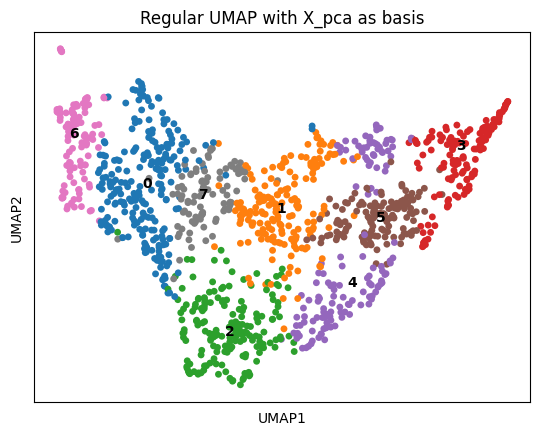

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


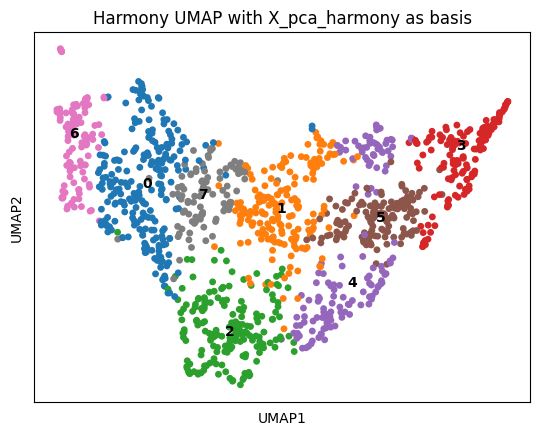

In [265]:
# Plot UMAP for regular PCA
plot_umap(adata, pca_key='X_pca', umap_key='umap', title_prefix='Regular')

# Plot UMAP for Harmony integrated PCA
plot_umap(adata, pca_key='X_pca_harmony', umap_key='X_umap_PCA_Harmony', title_prefix='Harmony')

### cell selections

<AxesSubplot: title={'center': 'Entropy per TF over clusters'}, xlabel='TF'>

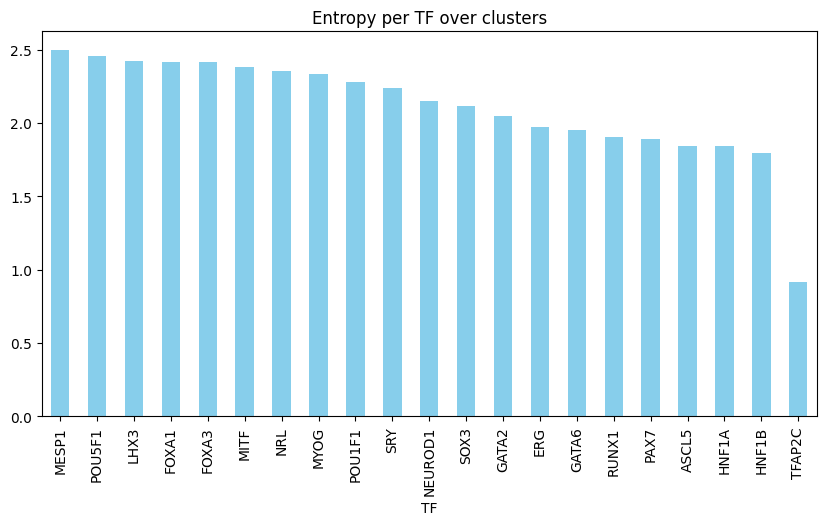

In [270]:
entropy_per_tf = calculate_entropy_per_tf(adata)
# print ordered histogram per TF
entropy_per_tf = entropy_per_tf.sort_values(ascending=False)
# plot histogram
entropy_per_tf.plot(kind='bar', figsize=(10, 5), color='skyblue', title='Entropy per TF over clusters')

<AxesSubplot: title={'center': 'TFs as a function of value_counts()'}>

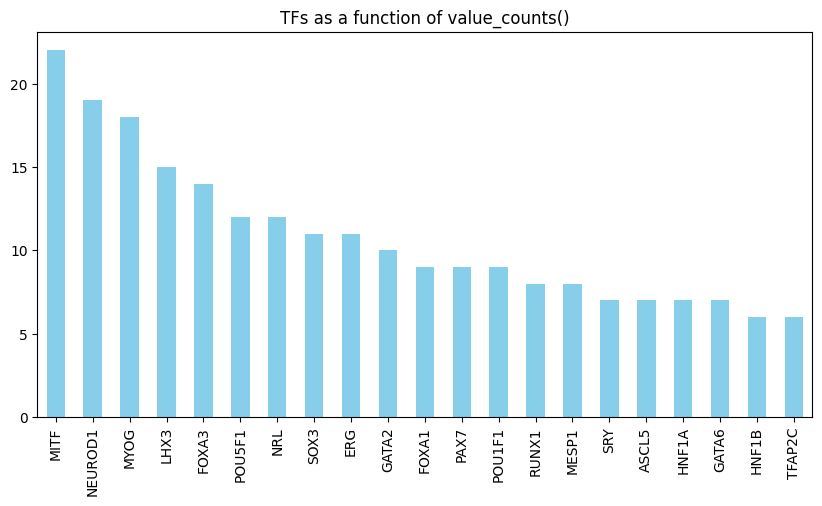

In [268]:
adata = select_samples(adata)

adata.obs['TF'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue', title='TFs as a function of value_counts()')

### save

In [271]:
adata.write_h5ad('../data/cleant/GSM33088__-SUESS.h5ad')
adata
del adata

## TF atlas

In [67]:
adata = sc.read_h5ad('../data/GSE217460_210322_TFAtlas_differentiated_raw.h5ad')
tdata = sc.read_h5ad('../data/GSE217460_210322_TFAtlas_differentiated.h5ad')

adata.obsm["X_pca"] = tdata.obsm['X_pca']
adata.obsm["X_pca_harmony"] = tdata.obsm["X_pca_harmony"]

del tdata

In [68]:
tf = "PAX2"

# Ensure the 'TF' column is treated as a string
adata.obs["TF"] = adata.obs["TF"].astype(str)

# Extract just the TF part after the '-' and create a new column (e.g., "New_TF")
adata.obs["New_TF"] = adata.obs["TF"].str.split("-").str[-1]

# sanity check
if tf in adata.obs["New_TF"].unique():
    print("TF is in the list")
else:
    print("TF is not in the list")

# # If you want to replace the original 'TF' column with these new categories:
adata.obs["TF"] = adata.obs["New_TF"]
adata.obs = adata.obs.drop(columns=["New_TF"])

TF is in the list


In [69]:
adata.X
if not sp.issparse(adata.X):
    adata.X = sp.csr_matrix(adata.X)
else:
    adata.X = adata.X

### perform PCA and plot UMAP

currently commented because the results were really bad? 

In [44]:
# sc.pp.pca(adata, svd_solver="auto") # uses ARpack
# import scanpy as sc
# from harmony import harmonize


# ## should I use batch of batchTF here? 
# adata.obsm["X_pca_harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch") # can use GPU

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


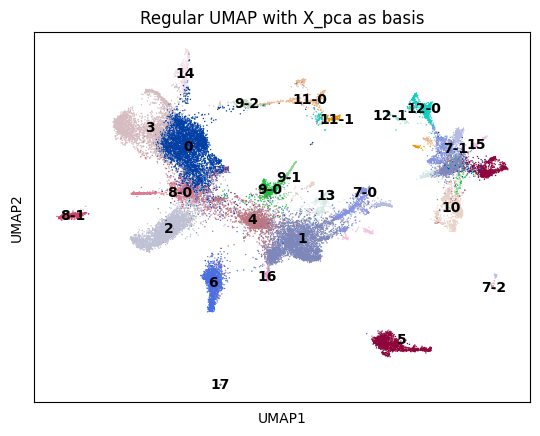

/home/msai/riemerpi001/.conda/envs/my_cell_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


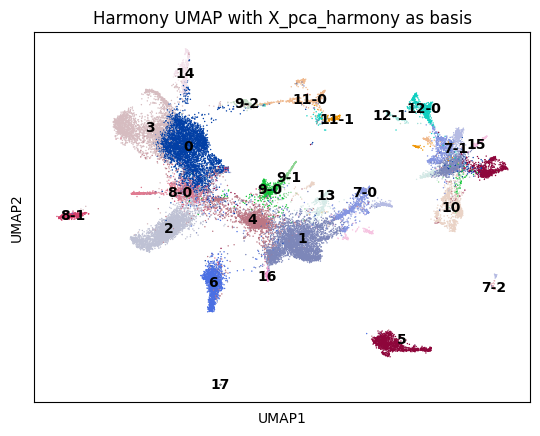

In [70]:
# Plot UMAP for regular PCA
plot_umap(adata, pca_key='X_pca', umap_key='umap', title_prefix='Regular')

# Plot UMAP for Harmony integrated PCA
plot_umap(adata, pca_key='X_pca_harmony', umap_key='X_umap_PCA_Harmony', title_prefix='Harmony')

### cell selections

<AxesSubplot: title={'center': 'Entropy per TF over clusters'}, xlabel='TF'>

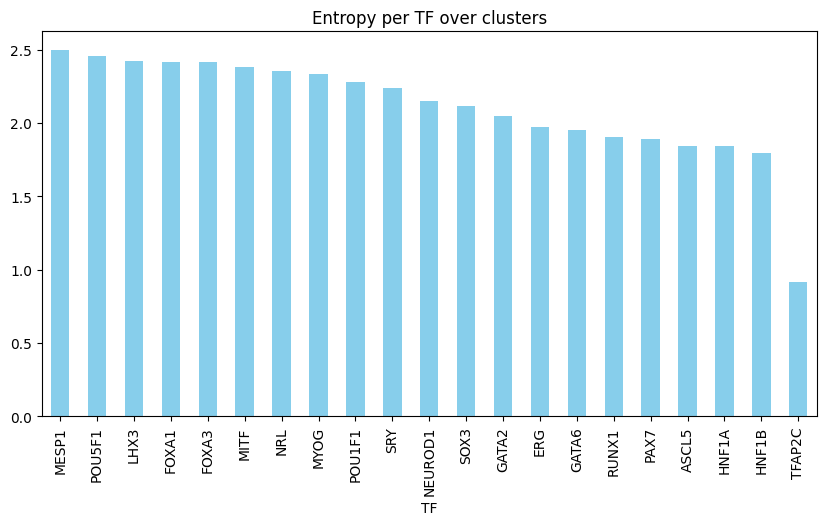

In [269]:
entropy_per_tf = calculate_entropy_per_tf(adata)
# print ordered histogram per TF
entropy_per_tf = entropy_per_tf.sort_values(ascending=False)
# plot histogram
entropy_per_tf.plot(kind='bar', figsize=(10, 5), color='skyblue', title='Entropy per TF over clusters')

<AxesSubplot: title={'center': 'TFs as a function of value_counts()'}>

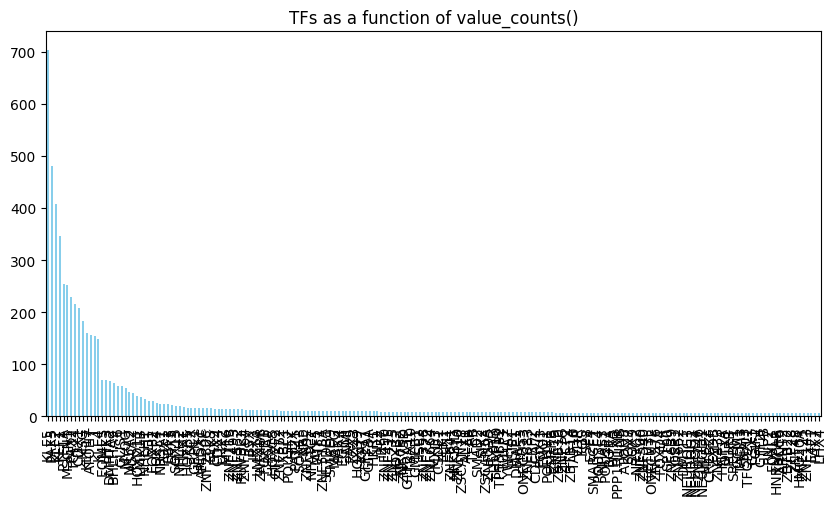

In [71]:
adata = select_samples(adata)

adata.obs['TF'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue', title='TFs as a function of value_counts()')

### save 

In [74]:
adata.write_h5ad('../data/cleant/GSE217460_210322_TFAtlas.h5ad')
adata
del adata


In [180]:
TFdata = sc.read_h5ad('../data/cleant/GSE217460_210322_TFAtlas.h5ad')